In [ ]:
# Introduction

# 1. Gathering / processing relevant data from NYCopenData 
# 2. Look at the kinds of distances : Euclidian, Network, Adjacency.
# 3. Create weighted paths to choose which ones have higher tree coverage.
# 4. That's the optimized pedestrian path
# 5. Visualie the data

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


In [8]:
import os
print(os.getcwd())

/Users/badriyah/Documents/GitHub/cdp-mapping-systems/Assignments


In [9]:
# I just used a subset of the data because the original dataset is too large (CHATGPT'S ADVICE)

tree_data = pd.read_csv('1.csv') #2015_Street_Tree_Census_-_Tree_Data_20240728
ped_data = pd.read_csv('2.csv') #Pedestrian_Mobility_Plan_Pedestrian_Demand_20240728

In [10]:
tree_data.head()
ped_data.head()

,the_geom,BoroCode,BoroName,BoroCD,CounDist,AssemDist,StSenDist,CongDist,street,segmentid,Rank,PMP_ID,NTA2020,Boro,Category,NTAName,FEMAFldz,FEMAFldT,HrcEvac,SHAPE_Leng
0,MULTILINESTRING ((-73.81665096623519 40.674537...,4,Queens,410,"28,32",31,10,5,122 STREET,55131,4,52434,QN1001,QN,Community,South Ozone Park,X,AREA OF MINIMAL FLOOD HAZARD,"5,6",326.224892
1,MULTILINESTRING ((-74.25422309679644 40.506165...,5,Staten Island,503,51,62,24,11,WARDS POINT AVENUE,16,5,79811,SI0305,SI,Baseline,Tottenville-Charleston,X,AREA OF MINIMAL FLOOD HAZARD,2,133.964227
2,MULTILINESTRING ((-73.82885385076081 40.698186...,4,Queens,409,29,24,14,5,120 STREET,56031,5,50784,QN0902,QN,Baseline,Richmond Hill,X,AREA OF MINIMAL FLOOD HAZARD,NaN,220.503354
3,MULTILINESTRING ((-73.78519954748839 40.718913...,4,Queens,408,24,24,"11,14",5,CROYDON ROAD,180320,5,49677,QN0804,QN,Baseline,Jamaica Estates-Holliswood,X,AREA OF MINIMAL FLOOD HAZARD,NaN,33.180523
4,MULTILINESTRING ((-74.15639270712379 40.632493...,5,Staten Island,501,49,61,23,11,MAPLE PARKWAY,8394,4,70756,SI0107,SI,Community,Mariner's Harbor-Arlington-Graniteville,X,AREA OF MINIMAL FLOOD HAZARD,"5,6",410.317355


In [14]:
# Filter the tree data for only the id, latitude, and longitude, and the health of the tree
# Filter relevant columns and drop missing values
tree_data = tree_data[['tree_id', 'latitude', 'longitude', 'health']].dropna()
ped_data = ped_data[['segmentid', 'Rank', 'NTAName', 'SHAPE_Leng']].dropna()

# CORRECT DATA TYPPPESSSSSSS
tree_data['latitude'] = tree_data['latitude'].astype(float)
tree_data['longitude'] = tree_data['longitude'].astype(float)

# Convert health column to numeric, coerce errors to NaN, then fill NaN with a default value
tree_data['health'] = pd.to_numeric(tree_data['health'], errors='coerce').fillna(0)

# Create GeoDataFrame for tree data
tree_gdf = gpd.GeoDataFrame(tree_data,
                            geometry=gpd.points_from_xy(tree_data.longitude, tree_data.latitude))


In [15]:
tree_gdf.head()

,tree_id,latitude,longitude,health,geometry
0,180683,40.723092,-73.844215,0.0,POINT (-73.84422 40.72309)
1,200540,40.794111,-73.818679,0.0,POINT (-73.81868 40.79411)
2,204026,40.717581,-73.936608,0.0,POINT (-73.93661 40.71758)
3,204337,40.713537,-73.934456,0.0,POINT (-73.93446 40.71354)
4,189565,40.666778,-73.975979,0.0,POINT (-73.97598 40.66678)


In [16]:
ped_data.head()

,segmentid,Rank,NTAName,SHAPE_Leng
0,55131,4,South Ozone Park,326.224892
1,16,5,Tottenville-Charleston,133.964227
2,56031,5,Richmond Hill,220.503354
3,180320,5,Jamaica Estates-Holliswood,33.180523
4,8394,4,Mariner's Harbor-Arlington-Graniteville,410.317355


DISTANCE

EUCLIDEAN DISTANCE: Straight-line distance
NETWORK: PATHS
ADJACENCY: CONNECTIONS BETWEEN NODES

In [17]:
# Initialize Graph
G = nx.Graph()

# Add nodes
for idx, row in tree_gdf.iterrows():
    G.add_node(row['tree_id'], pos=(row['longitude'], row['latitude']), health=row['health'])

# Add edges (connect consecutive nodes in tree_gdf)
for i in range(len(tree_gdf) - 1):
    start_point = tree_gdf.iloc[i]
    end_point = tree_gdf.iloc[i + 1]
    distance = np.linalg.norm((start_point.geometry.x - end_point.geometry.x,
                               start_point.geometry.y - end_point.geometry.y))
    G.add_edge(start_point['tree_id'], end_point['tree_id'], weight=distance)

In [18]:
# Print the number of nodes and edges - FOR NETWORK
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 490
Number of edges: 489


Optimizing Pedestrian Paths: Integrate tree data, create WEIGHTED path that prioritizes routes with high tree coverage + based on the health of the tree.
Remember... LOWER WEIGHT = PREFERRED ROUTE. 

In [19]:
# Euclidean distances
positions = nx.get_node_attributes(G, 'pos')
coords = np.array(list(positions.values()))
euclidean_dists = cdist(coords, coords, metric='euclidean')

# Dictionary for Euclidean distances
euclidean_dist_dict = {}
nodes = list(G.nodes())
for i, node_i in enumerate(nodes):
    for j, node_j in enumerate(nodes):
        euclidean_dist_dict[(node_i, node_j)] = euclidean_dists[i, j]

# Calculate network distances
network_dists = dict(nx.all_pairs_dijkstra_path_length(G))


In [31]:
# Compare distances.
# Just print them out so you don't get it mixed up again.
print("Euclidean distance between node 1 and node 2:", euclidean_dist_dict[(nodes[0], nodes[200])])
print("Network distance between node 1 and node 2:", network_dists[nodes[0]][nodes[200]])


Euclidean distance between node 1 and node 2: 0.14825563761483213
Network distance between node 1 and node 2: 28.100717919496937


So between node 1 and 2, eucleiean is 0.07547025371619756 - pure proximity
and between the same nodes, network distance is 0.07547025371619756 - following edges

SO BASICALLY. It's the same because it followed the same direct path.

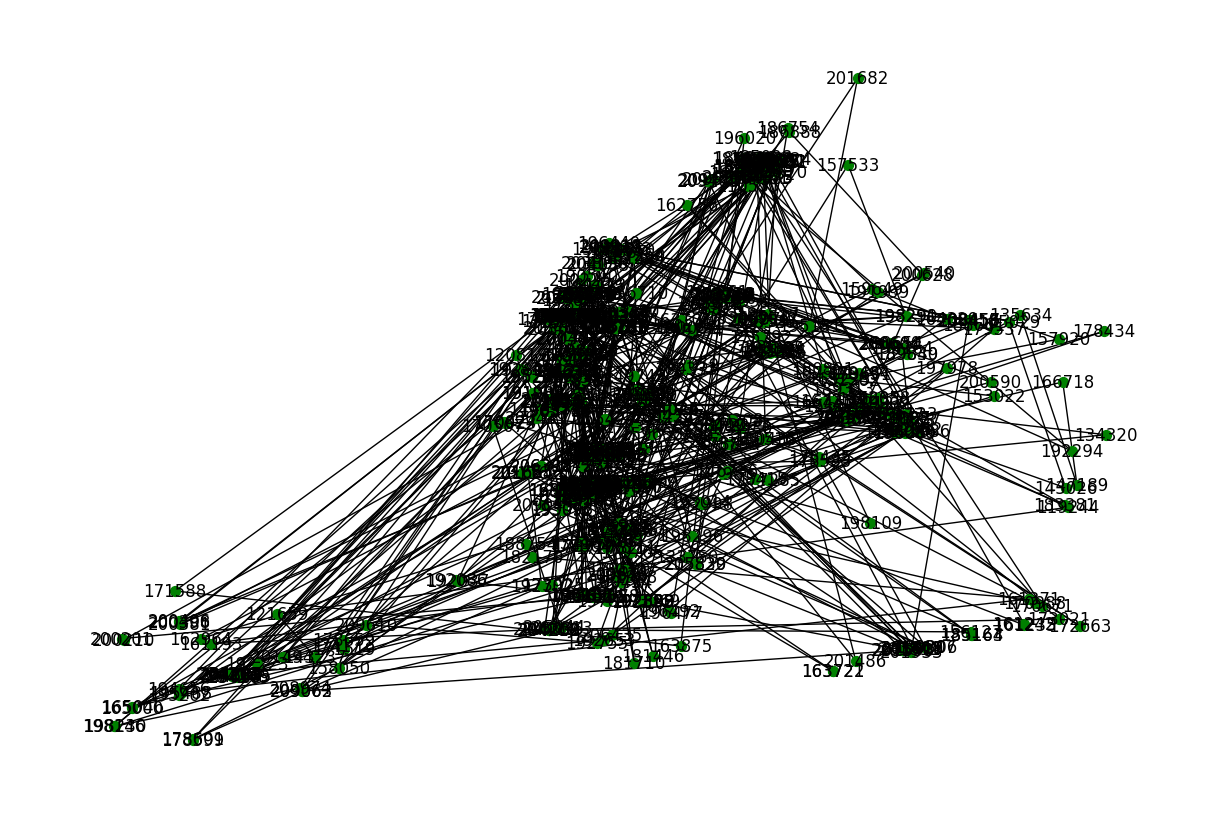

In [34]:
# Visualization
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='green')
plt.show()

# TO MAKE THIS MORE REAL APPLY THE GEOPANDAS TO IT.

In [33]:
# Visualization
pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(14, 10))
plt.show()



<Figure size 1400x1000 with 0 Axes>

In [ ]:
Normalize the coordinates

In [24]:
min_lat = min(x[1] for x in pos.values())
max_lat = max(x[1] for x in pos.values())
min_lon = min(x[0] for x in pos.values())
max_lon = max(x[0] for x in pos.values())

normalized_pos = {k: ((v[0] - min_lon) / (max_lon - min_lon), (v[1] - min_lat) / (max_lat - min_lat)) for k, v in pos.items()}


I'm using KAMADA KAWAI - which will make it more compact for the visualization part.

Spring Layout
Kamada Kawai
Shell (https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.drawing.layout.shell_layout.html)

In [26]:
pos_kamada_kawai = nx.kamada_kawai_layout(G, pos=normalized_pos)


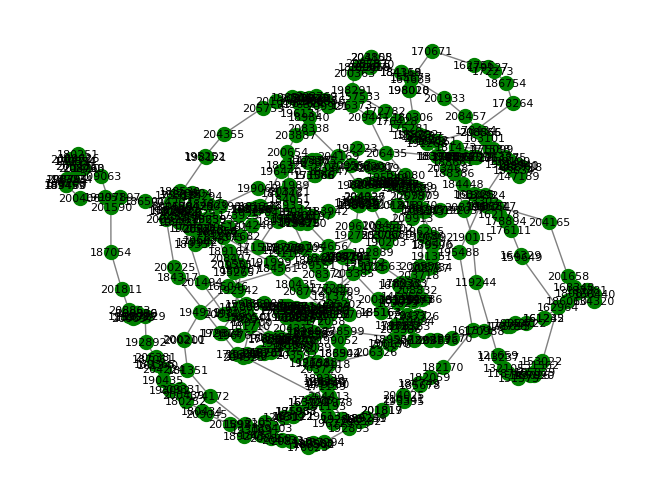

In [27]:
nx.draw(G, pos_kamada_kawai,
        node_size=100,
        node_color='green',
        edge_color='gray',
        font_size=8,
        with_labels=True)


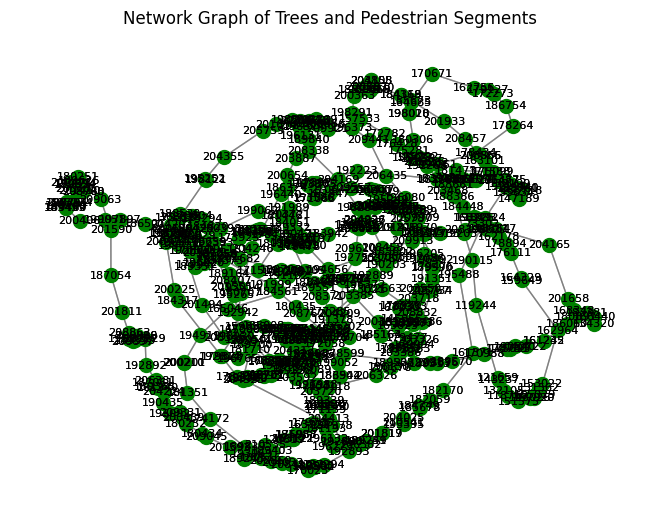

In [30]:
nx.draw(G, pos_kamada_kawai,
        node_size=100,
        node_color='green',
        edge_color='gray',
        font_size=8,
        with_labels=True)

# Adjust node and edge appearances
nx.draw_networkx_nodes(G, pos_kamada_kawai,
                       node_color='green',
                       node_size=50,
                       alpha=0.6)
nx.draw_networkx_edges(G, pos_kamada_kawai,
                       edge_color='gray',
                       alpha=0.5)

# Add labels for nodes
nx.draw_networkx_labels(G, pos_kamada_kawai,
                        labels={node: node for node in G.nodes()},
                        font_size=8)

plt.title('Network Graph of Trees and Pedestrian Segments')
plt.show()

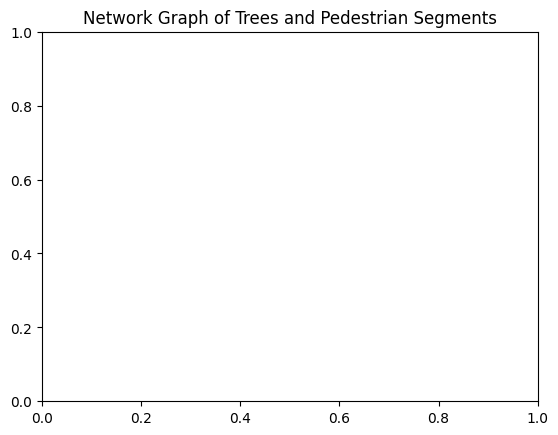

In [29]:
#TITLE IT!!!!!
plt.title('Network Graph of Trees and Pedestrian Segments')
plt.show()